In [1]:
"""
================================================================================
IMAGE FEATURE GENERATOR (HARALICK & HAAR-LIKE)
================================================================================
Authors: Giuseppe Riccio, Stefano Cavuoti
Date: 2026-02-24
Description:
    This script processes 2D image data (stored as flattened arrays in CSVs) 
    to extract advanced texture and structural features.
    
    Key functionalities:
    1. Reshapes flat data into 2D grayscale images.
    2. Calculates Haralick Texture Features (13 descriptors) across multiple 
       resolutions and directions (horizontal, vertical, diagonals, and mean).
    3. Calculates Haar-like features using integral images, including 
       computations for flipped versions of the input.
    4. Supports multi-resolution analysis for Haralick features.
    5. Exports results to separate CSV files for downstream machine learning tasks.

Dependencies:
    - numpy, pandas, matplotlib
    - mahotas (for Haralick features)
    - skimage (for Haar-like features)
    - opencv-python, PIL
================================================================================
"""

In [1]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import haar_like_feature_coord, haar_like_feature
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image
import mahotas as mh
import os
import pandas as pd
import cv2
from PIL import Image

In [2]:
# Start execution timer
start_time = time.time()

# Directory containing the source CSV files
# folder_path = '2kyr_new' + os.sep
folder_path = 'im2' + os.sep

# Configuration flags
debug = 0
use_fake = 0
use_haralick = 0
use_haar = 1
res_32 = True
haar_flipped = False

# Get the list of CSV files in the folder, sorted alphabetically
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
print(f"Files to process: {csv_files}")

Files to process: ['0512norm.csv', '1216norm.csv', '1621norm.csv', '2130norm.csv', '3035norm.csv', '3540norm.csv', '4050norm.csv', '5060norm.csv', '6070norm.csv', '7080norm.csv']


In [3]:
def main_haralick(I, hres, filename):
    """Calculates Haralick texture features for given resolutions."""
    if not debug:
        csv_out = open(filename, "w")
    else:
        csv_out = open("test_haralick_2.csv", "w")
    
    header = ""
    output = []
    print('\n\nHARALICK FEATURES CALCULATION\n\n')
    
    for i, r in enumerate(hres):
        print(f'\n\nStarting analysis with resolution {r}...')
        # Column headers for different directions
        curr_head_h = ",".join([f"haralick_r{r}_h_f{j}" for j in range(1, 14)])
        curr_head_v = ",".join([f"haralick_r{r}_v_f{j}" for j in range(1, 14)])
        curr_head_d2 = ",".join([f"haralick_r{r}_d2_f{j}" for j in range(1, 14)])
        curr_head_d1 = ",".join([f"haralick_r{r}_d1_f{j}" for j in range(1, 14)])
        curr_head_mean = ",".join([f"haralick_r{r}_mean_f{j}" for j in range(1, 14)])
        
        header = ",".join([header, curr_head_h, curr_head_v, curr_head_d2, curr_head_d1, curr_head_mean])
        
        # Create surrounding border to handle edges
        I_large = np.pad(I, (r,), 'constant', constant_values=(0,))
        
        curr_res_out = []
        for row in range(r, r + I.shape[1]):
            for col in range(r, r + I.shape[0]):
                # Extract local neighborhood (thumbnail) to analyze
                img_haralick_mini = I_large[row-r:row+r+1, col-r:col+r+1]
                # Separated in 4 directions
                features = mh.features.haralick(img_haralick_mini)   
                features_dir = np.ravel(features)
                # Mean across all four directions
                features_mean = features.mean(axis=0)
                features_all = np.concatenate([features_dir, features_mean])
                
                if res_32:
                    outtxt = ",".join(str(np.float32(f)) for f in features_all)
                else:
                    outtxt = ",".join(str(f) for f in features_all)
                curr_res_out.append(outtxt)
        output.append(curr_res_out)

    header = header[1:]
    csv_out.write(header + "\n")
    
    # Format and save the final rows
    for j in range(len(output[0])):
        curr = ""
        for l in range(len(output)):
            curr += "," + output[l][j]
        curr = curr[1:] + "\n"
        csv_out.write(curr)
                    
    csv_out.close()


In [4]:
def main_haarlike(I, w, h, feature_types, filename):
    """Calculates Haar-like features for the image."""
    if not debug:
        csv_out = open(filename, "w")
    else:
        csv_out = open("test_haarlike.csv", "w")
    
    header_list = []
    header_list_flipped = []
             
    print('\n\nHAAR-LIKE FEATURES CALCULATION\n\n')    
    
    # Build header dynamically based on feature types
    f_coord, f_type = haar_like_feature_coord(w, h, feature_types)
    for f_t in feature_types:
        type_size = len(np.where(f_type == f_t)[0])
        for n in range(type_size):
            clean_type = f_t.replace("type-", "").replace("-", "")
            header_list.append(f"haar_{clean_type}_{n+1}")
            header_list_flipped.append(f"haar_{clean_type}_{n+1}_flip")

    header = ",".join(header_list)
    if haar_flipped:
        print("Flipped image calculation ENABLED")
        header_flipped = ",".join(header_list_flipped)
        header += "," + header_flipped + "\n"
    else:
        header += "\n"
        print("Flipped image calculation DISABLED")
                
    csv_out.write(header)
    
    # Compute Integral Image
    ii = integral_image(I)
    haarfeatures = []

    # Calculate standard Haar-like features
    for row in range(I.shape[0]):
        for col in range(I.shape[1]):
            curr_hf = haar_like_feature(ii, row, col, w, h, feature_types)
            haarfeatures.append(curr_hf)

    # Calculate features on flipped image
    Iud = np.flipud(ii)
    Inew = np.fliplr(Iud)    
    haarfeatures_flipped = []
    for row in range(Inew.shape[0]):
                    
        for col in range(Inew.shape[1]):
            curr_hf = haar_like_feature(Inew, row, col, w, h, feature_types)
            haarfeatures_flipped.append(curr_hf)        
    
    # Flip the results back to align with original coordinates
    hf_fl = np.flipud(haarfeatures_flipped)
    
    # Save combined features   
    for i, l in enumerate(haarfeatures):
        hf_flipped = hf_fl[i]
        haar_str = ",".join(str(x) for x in l)
        haar_flip_str = ",".join(str(x) for x in hf_flipped)
        haar_final_str = f"{haar_str},{haar_flip_str}\n"
        csv_out.write(haar_final_str)
    
    csv_out.close()


Working directory: im2\
Reshaping file 0512norm.csv...


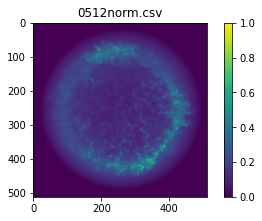



HAAR-LIKE FEATURES CALCULATION


Flipped image calculation DISABLED


KeyboardInterrupt: 

In [5]:
# Main Execution Loop
if debug:
    nfiles = 1
else:
    nfiles = len(csv_files)

xshape = 512
yshape = 512

######## HARALICK SETTINGS ##########
min_res = 1 # Minimum Haralick resolution    
         
max_res = 5 # Maximum Haralick resolution
         
haralick_matrix = list(range(min_res, max_res + 1))


######## HAAR-LIKE SETTINGS ##########
w = 5
h = 5
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']

print(f"Working directory: {folder_path}")

for i in range(nfiles):
    current_file = folder_path + csv_files[i]
    print(f"Reshaping file {csv_files[i]}...")
    
    # Read flat data from CSV
    df = pd.read_csv(current_file, usecols=["Total"])
    flat_data = df["Total"].to_numpy()
                     
    data2d = np.reshape(flat_data, (xshape, yshape))
    
    # Plot/Visualize input image
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(111)
    ax.set_title(csv_files[i])
                                                                                       
                                                              
    plt.imshow(data2d)
    plt.colorbar(orientation='vertical')
    plt.show()
    
    # Convert to grayscale representation
    if debug and use_fake:
        print("Using Debug Random Image")
        datagray = np.random.randint(0, 256, (10, 10))
    else:
        im = Image.fromarray(data2d, 'L')
        datagray = np.array(im)
    
    # Calculate Haralick features if enabled
    if use_haralick:
        output_name = csv_files[i].split(".")[0] + "_haralick.csv"
        main_haralick(datagray, haralick_matrix, output_name)
   
    # Calculate Haar-like features if enabled
    if use_haar:
        output_name = csv_files[i].split(".")[0] + "_haar.csv"
        main_haarlike(datagray, w, h, feature_types, output_name)

# Final duration stats
end_time = time.time()
total_sec = round(end_time - start_time)
print(f"Total Duration: {datetime.timedelta(seconds=total_sec)} h")
if nfiles > 0:
    mean_sec = round(total_sec / nfiles)
    print(f"Mean duration per object: {datetime.timedelta(seconds=mean_sec)} h")
print("END PROGRAM")